In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import re
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import matthews_corrcoef
import json as json

C:\Hyapp\Anaconda3-2019.3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Hyapp\Anaconda3-2019.3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Hyapp\Anaconda3-2019.3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [7]:
original_df = pd.read_csv('./data/merged_train_data.csv')

In [8]:
len(original_df)

1209214

In [9]:
original_df.head()

,comd_one,comd_two,output
0,"""C:\Windows\Microsoft.NET\Framework64\v4.0.303...","""LogonUI.exe"" /flags "":"" 0x0 /state0 "":"" 0xa11...",Not-Similar
1,"""C:\WINDOWS\system32\WindowsPowerShell\v1.0\Po...","""C:\Windows\Microsoft.NET\Framework64\v4.0.303...",Not-Similar
2,"""C:\WINDOWS\System32\sihclient.exe"" /cv 7gTB8U...","""C:\Windows\System32\MsiExec.exe"" /Y ""C:\WINDO...",Not-Similar
3,"""C:\Windows\Microsoft.NET\Framework\v4.0.30319...","""C:\WINDOWS\system32\WindowsPowerShell\v1.0\Po...",Not-Similar
4,"""C:\Windows\Microsoft.NET\Framework64\v4.0.303...","""C:\Windows\Microsoft.NET\Framework64\v4.0.303...",Similar


In [10]:
def tokenize_url(url:str):   
    url=url.replace("https://www.abc.com/entry/","")
    url=re.sub("(\W|_)+"," ",url)
    return url

In [11]:
def extract_features(df,field,training_data,testing_data, feature_type):
    """Extract features using different methods"""
    
    if "binary" in feature_type:
        
        # BINARY FEATURE REPRESENTATION
        cv= CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
  
    elif "counts" in feature_type:
        
        # COUNT BASED FEATURE REPRESENTATION
        cv= CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    else:    
        
        # TF-IDF BASED FEATURE REPRESENTATION
        tfidf_vectorizer=TfidfVectorizer(use_idf=True)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer


In [12]:
original_df['combined_comds'] = original_df['comd_one'] + ' '+ original_df['comd_two']

In [13]:
sampled_df = original_df.sample(n =1000000)
len(sampled_df)

1000000

In [14]:
def get_top_k_predictions(model,X_test,k):
    
    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = model.predict_proba(X_test)
    

    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_n = np.argsort(probs, axis=1)[:,-k:]
    
    
    # GET CATEGORY OF PREDICTIONS
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
  
    preds=[ item[::-1] for item in preds]
  
    return np.max(probs), preds

In [15]:
def _reciprocal_rank(true_labels: list, machine_preds: list):
    """Compute the reciprocal rank at cutoff k"""
    
    # add index to list only if machine predicted label exists in true labels
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_preds) if r in true_labels]

    rr = 0
    if len(tp_pos_list) > 0:
        # for RR we need position of first correct item
        first_pos_list = tp_pos_list[0]
        
        # rr = 1/rank
        rr = 1 / float(first_pos_list)

    return rr
def compute_mrr_at_k(items:list):
    """Compute the MRR (average RR) at cutoff k"""
    rr_total = 0
    
    for item in items:   
        rr_at_k = _reciprocal_rank(item[0],item[1])
        rr_total = rr_total + rr_at_k
        mrr = rr_total / 1/float(len(items))

    return mrr

def collect_preds(Y_test,Y_preds):
    """Collect all predictions and ground truth"""
    
    pred_gold_list=[[[Y_test[idx]],pred] for idx,pred in enumerate(Y_preds)]
    return pred_gold_list
             
def compute_accuracy(eval_items:list):
    correct=0
    total=0
    
    for item in eval_items:
        true_pred=item[0]
        machine_pred=set(item[1])
        
        for cat in true_pred:
            if cat in machine_pred:
                correct+=1
                break
    
    
    accuracy=correct/float(len(eval_items))
    return accuracy


In [16]:
def train_model(df,field,feature_rep,top_k):
    
    
    # GET A TRAIN TEST SPLIT (set seed for consistent results)
    rand_state=randint(0,100)
    training_data, testing_data = train_test_split(df, test_size=0.20, random_state = rand_state)

    # GET LABELS
    Y_train=training_data['output'].values
    Y_test=testing_data['output'].values
     
    # GET FEATURES
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,feature_rep)

    # INIT LOGISTIC REGRESSION CLASSIFIER
    scikit_log_reg = LogisticRegression(solver='saga',random_state=rand_state, C=1.0, penalty='l2',max_iter=100, multi_class='auto')
    model=scikit_log_reg.fit(X_train,Y_train)

    # GET TOP K PREDICTIONS
    probs, preds=get_top_k_predictions(model,X_test,top_k)
    
    # GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS - for ease of evaluation
    eval_items=collect_preds(Y_test,preds)
    
    # GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
 
    accuracy=round(compute_accuracy(eval_items),4)
    mrr_at_k=round(compute_mrr_at_k(eval_items),4)
    
    return model,feature_transformer,accuracy,mrr_at_k,testing_data,confusion_matrix(Y_test,preds),matthews_corrcoef(Y_test,preds)


In [17]:
from sklearn.metrics import confusion_matrix
field = 'combined_comds'
feature_rep='tfidf'
top_k=1
model,transformer,accuracy,mrr_at_k, testing_data, conf_matr, mcc = train_model(sampled_df,field,feature_rep,top_k)
print("\nAccuracy={0}".format(accuracy))


Accuracy=0.9639


In [18]:
conf_matr

array([[141200,     72],
       [  7147,  51581]], dtype=int64)

In [14]:
tn, fp, fn, tp = conf_matr.ravel()

In [15]:
tn, tp

(141499, 51267)

In [16]:
fn, fp

(7141, 93)

In [17]:
mcc

0.9128840784689561

In [18]:
0.913-0.859

0.05400000000000005

In [19]:
unseen_df = original_df[~original_df.isin(sampled_df)].dropna()

unseen_df = unseen_df.reset_index(drop=True)

In [34]:
wrong_predicted =[]

wrong_results = []
for j in range(100):
    total_wrong = 0
    for i in range(1000):
        unseen_idx = randint(0,len(unseen_df)-1)
        orig_output = unseen_df.loc[unseen_idx]['output']
        test_features = transformer.transform([unseen_df.loc[unseen_idx]['combined_comds']])
        pred_prob, pred_output = get_top_k_predictions(model,test_features,1)
        #print("\noriginal value is: {0}; Predicted value is: {1}; with a prob of: {2}".format(orig_output,pred_output[0][0],pred_prob))
        if orig_output!= pred_output[0][0]:
            total_wrong+=1
            wrong_predicted.append(unseen_idx)
    wrong_results.append(total_wrong)

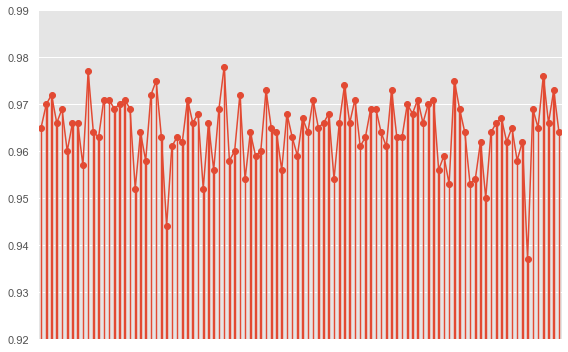

In [35]:
wrong_results_modified = [round(1-(wrong/1000),3) for wrong in wrong_results]
wrong_df = pd.DataFrame(wrong_results_modified, columns=['Correct_Ratio'])

ax = wrong_df[['Correct_Ratio']].plot( linestyle='-', marker='o', legend=False)
wrong_df[['Correct_Ratio']].plot( kind='bar', ax=ax,figsize=(8,5),legend=False)
plt.ylim(0.92, 0.99)
ax.axes.xaxis.set_visible(False)
plt.tight_layout()
plt.show()

In [17]:
def test_comds(comd_one, comd_two):
    new_string = comd_one + comd_two
    test_features = transformer.transform([new_string])
    pred_prob, pred_output = get_top_k_predictions(model,test_features,1)
    #print("Predicted class is: {0}; with a probability of: {1}".format(pred_output[0][0], round(pred_prob,4)))
    return pred_output[0][0]

In [59]:
unseen_idx = randint(0,len(unseen_df))
test_comds(unseen_df.loc[unseen_idx]['comd_one'], unseen_df.loc[unseen_idx]['comd_two'] )

'Not-Similar'

In [24]:
unseen_df.loc[unseen_idx]['comd_one'], unseen_df.loc[unseen_idx]['comd_two']

('"LogonUI.exe" /flags ":" 0x0 /state0 ":" 0xad59d855 /state1 ":" 0x41c64e6d ',
 '"c:\\WINDOWS\\Microsoft.NET\\Framework\\v4.0.30319\\ngen.exe" install "Microsoft.Office.Tools.v4.0.Framework, Version=10.0.0.0, Culture=neutral, PublicKeyToken=b03f5f7f11d50a3a" /queue ":" 3 /NoDependencies ')

In [25]:
cmd_one = '"C:\\Windows\\Microsoft.NET\\Framework\\v4.0.30319\\ngen.exe" install "WindowsBase, Version=4.0.0.0, Culture=neutral, PublicKeyToken=31bf3856ad364e35" /NoDependencies /noroot /version ":" v4.0.30319 /LegacyServiceBehavior '
cmd_two ='"C:\\Program Files (x86)\\MS Office 2016\\Office16\\POWERPNT.EXE" "C:\\Users\\zhussain\\study\\internship\\Literature Review\\deliverable.pptx" /ou "" '
test_comds(cmd_one, cmd_two)   

Predicted class is: Not-Similar; with a probability of: 0.9999


In [26]:
cmd_one = 'change port com12=com1'
cmd_two = 'chgport com5=com1'
test_comds(cmd_one, cmd_two)

Predicted class is: Similar; with a probability of: 1.0


In [27]:
cmd_one = 'query user user /server:Server64'
cmd_two =  'quser user /server:Server99'
test_comds(cmd_one, cmd_two)

Predicted class is: Similar; with a probability of: 1.0


In [28]:
cmd_one = 'ftp> send d:\web2\script.py'
cmd_two = 'ftp> put d:\web1\script.txt'
test_comds(cmd_one, cmd_two)

Predicted class is: Similar; with a probability of: 1.0


In [29]:
cmd_one = 'ftp>get remote_file.py [local_file.py]'
cmd_two = 'ftp>recv remote_file.py [local_file.py]'
test_comds(cmd_one, cmd_two)

Predicted class is: Similar; with a probability of: 1.0


In [30]:
cmd_one = 'Fc /a File1.txt File2.txt'
cmd_two = 'Fc /a python_file1.py image_file2.jpeg'
test_comds(cmd_one, cmd_two)

Predicted class is: Similar; with a probability of: 1.0


In [31]:
cmd_one = 'chkdsk /f /r /x /b c'
cmd_two = 'chkdsk /f /r /x /b d'
test_comds(cmd_one, cmd_two)

Predicted class is: Similar; with a probability of: 1.0


In [32]:
cmd_one = 'repair-bde <root> <target> -rk | rp <root>'
cmd_two = 'repair-bde c: d: -rk e:\restore.bek'
test_comds(cmd_one, cmd_two)

Predicted class is: Similar; with a probability of: 1.0


In [33]:
cmd_one = 'repair-bde <root> <target> -rk | rp <root>'
cmd_two = 'empty string'
test_comds(cmd_one, cmd_two)

Predicted class is: Similar; with a probability of: 1.0


In [34]:
cmd_one = 'git.exe commit -m test'
cmd_two = 'git.exe commit -m "test"'
test_comds(cmd_one, cmd_two)

Predicted class is: Not-Similar; with a probability of: 0.9953


In [22]:
with open('./dl_sentence_pair.txt', 'r') as wind_file:
        sen_pair =json.load(wind_file)

In [23]:
with open('./dl_binary.txt', 'r') as wind_file:
        dl_binary =json.load(wind_file)

In [37]:
len(sen_pair), len(dl_binary)

(100, 100)

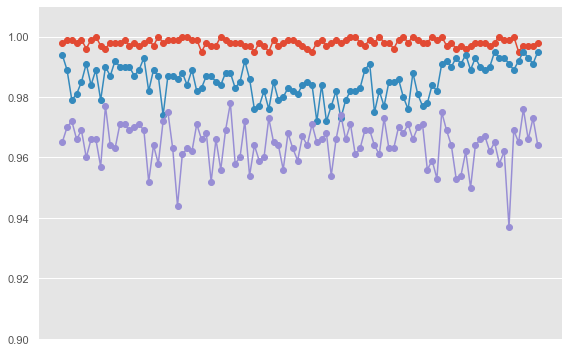

In [36]:
sen_pair_modified = [round(1-(wrong/1000),3) for wrong in sen_pair]
sen_pair_df = pd.DataFrame(sen_pair_modified, columns=['Correct_Ratio'])
dl_binary_modified = [round(1-(wrong/1000),3) for wrong in dl_binary]
dl_binary_df = pd.DataFrame(dl_binary_modified, columns=['Correct_Ratio'])

ax = sen_pair_df[['Correct_Ratio']].plot( kind='line', marker='o', figsize=(8,5),legend=False)
dl_binary_df[['Correct_Ratio']].plot( kind='line', marker='o', figsize=(8,5),ax=ax,legend=False)
wrong_df[['Correct_Ratio']].plot( kind='line', marker='o', ax=ax,figsize=(8,5),legend=False)
plt.ylim(0.9, 1.01)
ax.axes.xaxis.set_visible(False)
plt.tight_layout()
plt.show()

In [37]:
baseline_df = wrong_df.rename(columns = {'Correct_Ratio': 'Baseline_Correct_Ratio'})

sen_pair_df = sen_pair_df.rename(columns={'Correct_Ratio': 'DL_Sen_Pair_Correct_Ratio'})
dl_binary_df = dl_binary_df.rename(columns = {'Correct_Ratio': 'DL_Binary_Correct_Ratio'})

In [38]:
correct_ratio_comp = pd.DataFrame()
correct_ratio_comp = sen_pair_df.copy()
correct_ratio_comp['DL_Binary_Correct_Ratio'] = dl_binary_df['DL_Binary_Correct_Ratio']
correct_ratio_comp['Baseline_Correct_Ratio'] = baseline_df['Baseline_Correct_Ratio']

In [39]:
correct_ratio_comp

,DL_Sen_Pair_Correct_Ratio,DL_Binary_Correct_Ratio,Baseline_Correct_Ratio
0,0.998,0.994,0.965
1,0.999,0.989,0.970
2,0.999,0.979,0.972
3,0.998,0.981,0.966
4,0.999,0.985,0.969
...,...,...,...
95,0.995,0.992,0.965
96,0.997,0.995,0.976
97,0.997,0.993,0.966
98,0.997,0.991,0.973


In [40]:
correct_pred_comp = pd.DataFrame()
correct_pred_comp['DL_Sentence_Pair_Classifier'] = sen_pair
correct_pred_comp['Logistic_Regression'] = wrong_results
correct_pred_comp['DL_Document_Classifier'] = dl_binary

correct_pred_comp = correct_pred_comp.sample(frac=1).reset_index(drop=True)

In [42]:
correct_pred_comp['Logistic_Regression'].max(), correct_pred_comp['DL_Sentence_Pair_Classifier'].max(), correct_pred_comp['DL_Document_Classifier'].max()

(63, 5, 28)

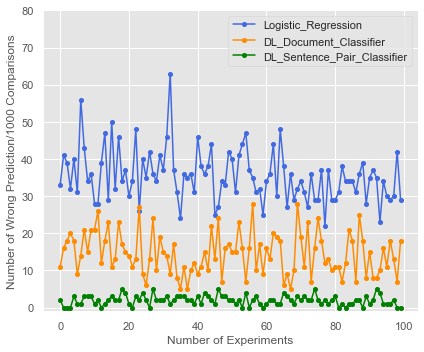

In [43]:
plt.style.use('ggplot')
correct_pred_comp.plot( y=["Logistic_Regression", "DL_Document_Classifier", "DL_Sentence_Pair_Classifier"], figsize=(6,5),
                        color=['royalblue', 'darkorange', 'green'], marker= 'o', ms=4)
plt.ylim(-1, 80)
plt.xlabel('Number of Experiments')
plt.ylabel('Number of Wrong Prediction/1000 Comparisons')
plt.tight_layout()
plt.savefig('./results/model_comparison_evaluation')
plt.show()

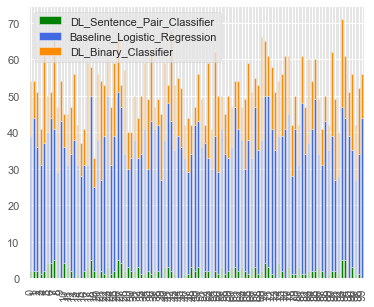

In [46]:
plt.style.use('ggplot')
correct_pred_comp.plot(kind='bar', figsize=(6,5), color=['green','royalblue', 'darkorange'] , stacked=True);

In [47]:
correct_pred_comp.index

RangeIndex(start=0, stop=100, step=1)

In [5]:
validation_data = pd.read_csv('./data/validation_data_classified.csv')

In [6]:
validation_data

,comd_one,comd_two,output
0,"""C:\Windows\system32\sfc/scannow""","""C:\Windows\system32\sfc/scannow""",Similar
1,"""C:\Windows\system32\sfc/scannow""","""C:\Windows\system32\netstat"" -b",Not-Similar
2,"""C:\Windows\system32\sfc/scannow""","""C:\Windows\system32\getmac""",Not-Similar
3,"""C:\Windows\system32\sfc/scannow""","""C:\Windows\system32\robocopy"" ""c:users "" flar...",Not-Similar
4,"""C:\Windows\system32\sfc/scannow""","""C:\Windows\system32\hostname""",Not-Similar
...,...,...,...
1535,"""C:\WINDOWS\System32\Upfc.exe"" /launchtype per...","""C:\Program Files\Amazon\AWSCLIV2\aws.exe"" cli",Not-Similar
1536,"""C:\WINDOWS\System32\Upfc.exe"" /launchtype per...","""C:\Program Files\Amazon\AWSCLIV2\aws.exe"" con...",Not-Similar
1537,"""C:\Program Files\Amazon\AWSCLIV2\aws.exe"" cli","""C:\Program Files\Amazon\AWSCLIV2\aws.exe"" cli",Similar
1538,"""C:\Program Files\Amazon\AWSCLIV2\aws.exe"" cli","""C:\Program Files\Amazon\AWSCLIV2\aws.exe"" con...",Similar


In [19]:
sim_total = 0
not_sim_total = 0
wrong_total=0
for j in range(len(validation_data)):
    comd_one = validation_data.loc[j]['comd_one']
    comd_two = validation_data.loc[j]['comd_two']
    result = validation_data.loc[j]['output']
    pred_result = test_comds(comd_one, comd_two)
    if result==pred_result and result=='Similar':
        sim_total+=1
    elif result==pred_result and result=='Not-Similar':
        not_sim_total+=1
    else:
        wrong_total+=1   